In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset
df = pd.read_csv("chemberta_features.csv")  # Ensure the dataset has embeddings & target

# Extract embeddings for each molecule
X1 = df[[f"feat_1_{i}" for i in range(384)]].values  # First molecule embedding
X2 = df[[f"feat_2_{i}" for i in range(384)]].values  # Second molecule embedding
y = df[["BetaT","GammaT", "BetaV", "GammaV"]].values  # Replace with actual target property

# First, split into 80% training and 20% temporary (validation + test)
X1_train, X1_temp, X2_train, X2_temp, y_train, y_temp = train_test_split(X1, X2, y, test_size=0.2, random_state=42)

# Then, split the remaining 20% into 10% validation and 10% test
X1_val, X1_test, X2_val, X2_test, y_val, y_test = train_test_split(X1_temp, X2_temp, y_temp, test_size=0.5, random_state=42)
                                                                   
# Convert to NumPy arrays (needed for TensorFlow)
X1_train, X2_train, y_train = np.array(X1_train), np.array(X2_train), np.array(y_train)
X1_val, X2_val, y_val = np.array(X1_val), np.array(X2_val), np.array(y_val)
X1_test, X2_test, y_test = np.array(X1_test), np.array(X2_test), np.array(y_test)


In [2]:
# Define input layers (Ensure input_dim matches your embeddings)
input_dim = 384  # This should match the size of ChemBERTa embeddings

input_1 = keras.Input(shape=(input_dim,))
input_2 = keras.Input(shape=(input_dim,))

# Shared transformation (Optional)
shared_dense = keras.Sequential([
    layers.Dense(256, activation="relu"),
    layers.Dense(256, activation="relu")
])

# Apply shared transformation to both molecule embeddings
phi1 = shared_dense(input_1)
phi2 = shared_dense(input_2)

# Sum aggregation
agg = layers.Add()([phi1, phi2])

# Final prediction layers (MLP)
output = layers.Dense(128, activation="relu")(agg)
output = layers.BatchNormalization()(output)  # Normalize before next layer
output = layers.Dense(64, activation="relu")(output)
output = layers.BatchNormalization()(output)  # Normalize before final layer
output = layers.Dense(4, activation="linear")(output)  # Regression output

# Create model
model = keras.Model(inputs=[input_1, input_2], outputs=output)

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse", metrics=["mae"])


In [3]:
# Train model
batch_size = 32
epochs = 100

history = model.fit(
    [X1_train, X2_train], y_train,
    validation_data=([X1_val, X2_val], y_val),
    epochs=epochs,
    batch_size=batch_size
)


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.1358 - mae: 1.1730 - val_loss: 0.9804 - val_mae: 0.9597
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9574 - mae: 0.8878 - val_loss: 0.7869 - val_mae: 0.8508
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6994 - mae: 0.7831 - val_loss: 0.5385 - val_mae: 0.6763
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5182 - mae: 0.6774 - val_loss: 0.3378 - val_mae: 0.5215
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3733 - mae: 0.5713 - val_loss: 0.2149 - val_mae: 0.4011
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2614 - mae: 0.4593 - val_loss: 0.1230 - val_mae: 0.2773
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1591 - mae: 0.3482 - val_loss: 0.0879 - val_mae: 0.2384
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0964 - mae: 0.2575 - val_loss: 0.0540 - val_mae: 0.1853
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.055

In [4]:
# Evaluate on test set
y_pred = model.predict([X1_test, X2_test])

# Convert tensors to NumPy arrays
y_true = y_test.flatten()
y_pred_f = y_pred.flatten()

# Compute evaluation metrics
mae = mean_absolute_error(y_true, y_pred_f)
mse = mean_squared_error(y_true, y_pred_f)
r2 = r2_score(y_true, y_pred_f)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Mean Absolute Error (MAE): 0.0502
Mean Squared Error (MSE): 0.0052
R² Score: 0.5357


In [5]:
# Define target names
target_columns = ["BetaT", "GammaT", "BetaV", "GammaV"]

# Compute RMSE for each target individually
rmse_values = {}
for i, target in enumerate(target_columns):
    rmse = np.sqrt(mean_squared_error(y_test[:, i], y_pred[:, i]))  # RMSE Calculation
    rmse_values[target] = rmse
    r2 = r2_score(y_test[:, i], y_pred[:, i])
    print(f"RMSE for {target}: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

RMSE for BetaT: 0.0600
R² Score: -4.0955
RMSE for GammaT: 0.1003
R² Score: 0.7503
RMSE for BetaV: 0.0404
R² Score: -2027.4407
RMSE for GammaV: 0.0747
R² Score: -1.1955


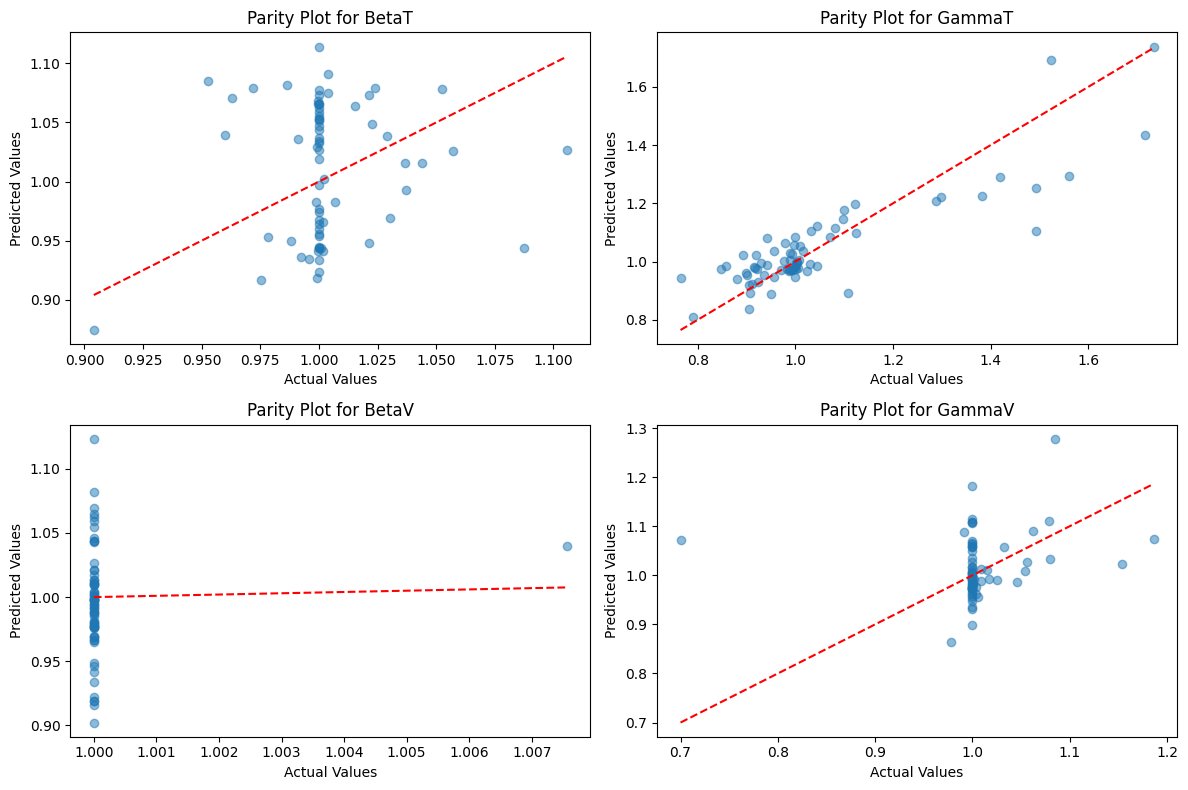

In [6]:
import matplotlib.pyplot as plt

# Create parity plots
plt.figure(figsize=(12, 8))

for i, target in enumerate(target_columns):
    plt.subplot(2, 2, i + 1)  # 2x2 subplot layout
    plt.scatter(y_test[:, i], y_pred[:, i], alpha=0.5)
    plt.plot([min(y_test[:, i]), max(y_test[:, i])], 
             [min(y_test[:, i]), max(y_test[:, i])], 
             color="red", linestyle="--")  # Diagonal parity line
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Parity Plot for {target}")

plt.tight_layout()
plt.show()
